# Recognize Facial Expressions Using Deep Learning, Densenet161, PyTorch and Transfer Learning


The Facial Expression Recognition can be featured as one of the classification jobs people might like to include in the set of computer vision. The job of our project will be to look through a camera that will be used as eyes for the machine and classify the face of the person (if any) based on his current expression/mood.

##Dataset
I found this dataset on kaggle, and it represents an image classification problem; since the data consists of six classes with each class containing between 3000-7000 images with six classes as 'Happy', 'Suprise', 'Sad', 'Fear', 'Angry', 'Neutral'.

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

In [ ]:
dataset_url = 'https://www.kaggle.com/apollo2506/facial-recognition-dataset'

In [ ]:
od.download(dataset_url)

100%|██████████| 59.7M/59.7M [00:00<00:00, 141MB/s]


In [ ]:
import os
dataset = './facial-recognition-dataset'
print(os.listdir(dataset))


['Training', 'Testing']


In [ ]:
classes = os.listdir(dataset + "/Training"+ "/Training")
print(classes)

['Angry', 'Sad', 'Suprise', 'Fear', 'Happy', 'Neutral']


In [ ]:
data_dir = dataset

train_dir = data_dir + '/Training' + '/Training'
test_dir = data_dir + '/Testing' + '/Testing'

In [ ]:
count = []
for folder in classes:
    num_images = len(os.listdir(train_dir+'/'+ folder))
    count.append(num_images)
    print(f'There are {num_images} images in the {folder} category.')

There are 3995 images in the Angry category.
There are 4830 images in the Sad category.
There are 3171 images in the Suprise category.
There are 4097 images in the Fear category.
There are 7215 images in the Happy category.
There are 4965 images in the Neutral category.


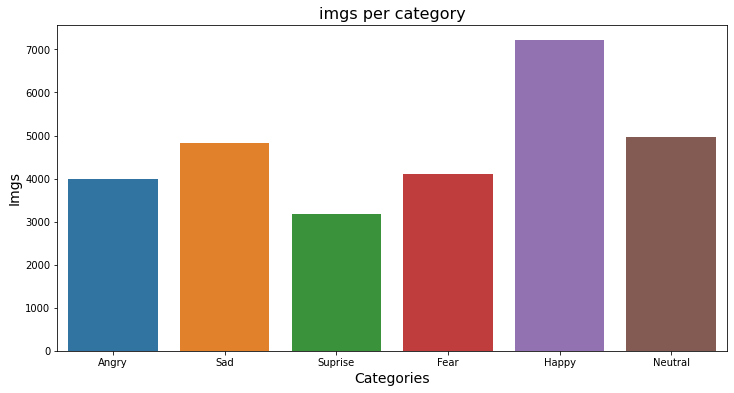

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.barplot(x=classes, y=count)
plt.title('imgs per category', size=16)
plt.ylabel('Imgs', size=14)
plt.xlabel('Categories', size=14)
plt.show;

In [ ]:
import numpy as np
import torch
import torchvision
import tarfile
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as tt
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns

from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid


#GPU Utilities 


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

# Creating a Custom PyTorch Dataset

In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

In [ ]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
 
train_tfms = tt.Compose([
                         tt.Resize(64),
                         tt.RandomCrop(64, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         #tt.RandomRotate,
                         #tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         #tt.ColorJitter(brightness=.1, contrast=.8, saturation=0.5, hue=0.12),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

# Creating Training and Validation Sets

In [ ]:
train_ds = ImageFolder(train_dir, train_tfms)
test_ds = ImageFolder(test_dir, valid_tfms)

In [ ]:
def show_example(img, label):
    print(f'Label: {train_ds.classes[label]} ({label})')
    print(f'image.shape: {img.shape}')
    plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Angry (0)
image.shape: torch.Size([3, 64, 64])
None


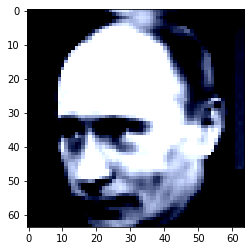

In [ ]:
print(show_example(*train_ds[1]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Angry (0)
image.shape: torch.Size([3, 64, 64])
None


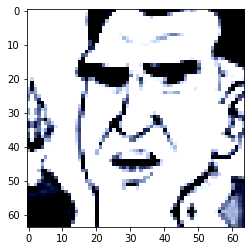

In [ ]:
print(show_example(*train_ds[101]))

In [ ]:
batch_size= 128

In [ ]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=6, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=6, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images[:64], *stats)
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


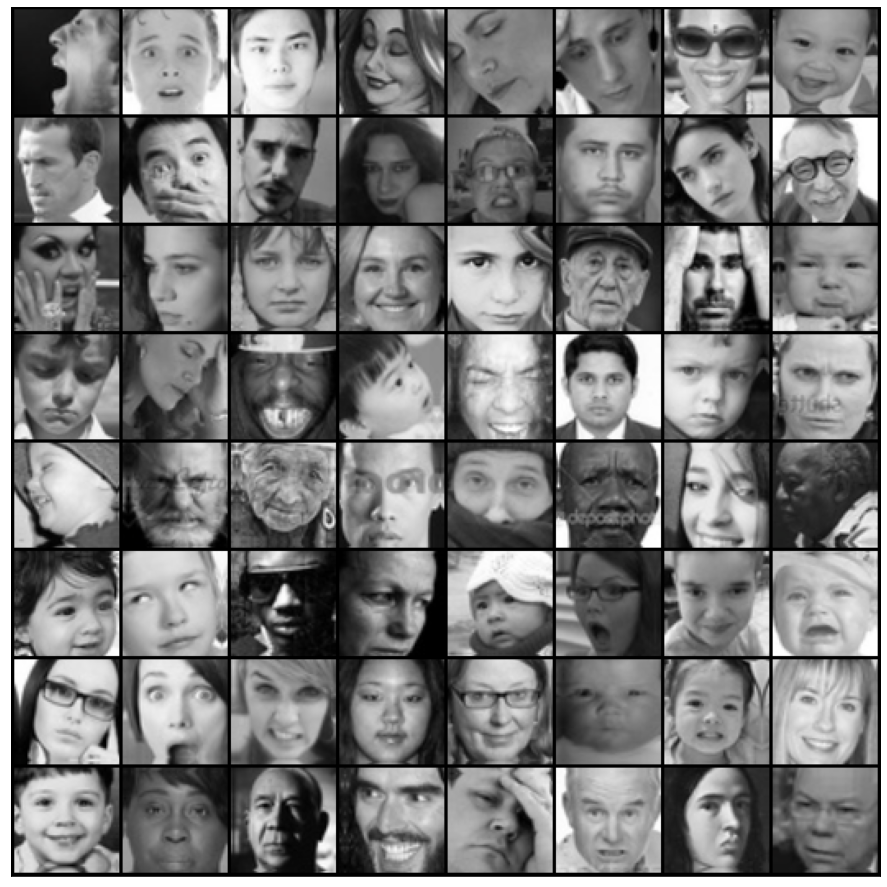

In [ ]:
show_batch(train_dl)

#Modifying a Pretrained Model (DenseNet161)
Recent work has shown that convolutional networks can be substantially deeper, more accurate, and efficient to train if they contain shorter connections between layers close to the input and those close to the output. In this paper, we embrace this observation and introduce the Dense Convolutional Network (DenseNet), which connects each layer to every other layer in a feed-forward fashion. Whereas traditional convolutional networks with L layers have L connections - one between each layer and its subsequent layer - our network has L(L+1)/2 direct connections. For each layer, the feature-maps of all preceding layers are used as inputs, and its own feature-maps are used as inputs into all subsequent layers. DenseNets have several compelling advantages: they alleviate the vanishing-gradient problem, strengthen feature propagation, encourage feature reuse, and substantially reduce the number of parameters. We evaluate our proposed architecture on four highly competitive object recognition benchmark tasks (CIFAR-10, CIFAR-100, SVHN, and ImageNet). DenseNets obtain significant improvements over the state-of-the-art on most of them, whilst requiring less memory and computation to achieve high performance. Code and models are available at this https URL.
Authors: Gao Huang, Zhuang Liu, Kilian Q. Weinberger, Laurens van der Maaten

<img src="https://imgur.com/oiTdqJL.jpg" style="max-width:420px; margin-bottom:32px"/>

<img src="https://www.researchgate.net/publication/341582569/figure/fig5/AS:894154146066448@1590194369708/Block-diagram-of-DenseNet-161-architecture.ppm" style="max-width:420px; margin-bottom:32px"/>

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
from torchvision import models

class Densnet161Model(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.densenet161(pretrained=pretrained)
        # Replace last layer
        
        self.network.fc = nn.Linear(self.network.classifier.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

##Transfer Learning:
The basic premise of transfer learning is simple: take a model trained on a large dataset and transfer its knowledge to a smaller dataset. For object recognition with a CNN, we freeze the early convolutional layers of the network and only train the last few layers which make a prediction. The idea is the convolutional layers extract general, low-level features that are applicable across images — such as edges, patterns, gradients — and the later layers identify specific features within an image such as eyes or wheels.
<img src="https://miro.medium.com/max/1276/1*ZkPBqU8vx2vAgcLpz9pi5g.jpeg" style="max-width:420px; margin-bottom:32px"/>

#Training Loop

In [ ]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

#Finetuning the Pretrained Model


In [ ]:
model = Densnet161Model(6,pretrained=True)
to_device(model, device)

Densnet161Model(
  (network): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(144, eps=1e-05, mom

In [ ]:
history = [evaluate(model, test_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[{'val_acc': 0.0, 'val_loss': 10.76215934753418}]

In [ ]:
%%time
history += fit_one_cycle(20,0.001,model,train_dl,test_dl,weight_decay=0.01,grad_clip=0.01,opt_func=torch.optim.Adam)

  0%|          | 0/221 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0],last_lr: 0.00010, train_loss: 3.6155, val_loss: 2.8193, val_acc: 0.2834


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00028, train_loss: 1.2251, val_loss: 1.6256, val_acc: 0.3437


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00052, train_loss: 1.0864, val_loss: 1.5082, val_acc: 0.4365


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00076, train_loss: 1.1340, val_loss: 1.5333, val_acc: 0.4374


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00094, train_loss: 1.1530, val_loss: 1.5931, val_acc: 0.3234


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00100, train_loss: 1.1787, val_loss: 1.7728, val_acc: 0.2650


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [6],last_lr: 0.00099, train_loss: 1.1849, val_loss: 1.7218, val_acc: 0.3038


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [7],last_lr: 0.00095, train_loss: 1.1761, val_loss: 1.8719, val_acc: 0.3082


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [8],last_lr: 0.00089, train_loss: 1.1772, val_loss: 1.9974, val_acc: 0.2949


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [9],last_lr: 0.00081, train_loss: 1.1673, val_loss: 2.2282, val_acc: 0.3138


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [10],last_lr: 0.00072, train_loss: 1.1471, val_loss: 2.2850, val_acc: 0.3139


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [11],last_lr: 0.00061, train_loss: 1.1258, val_loss: 2.2627, val_acc: 0.2699


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [12],last_lr: 0.00050, train_loss: 1.0965, val_loss: 2.0762, val_acc: 0.3063


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [13],last_lr: 0.00039, train_loss: 1.0717, val_loss: 1.9844, val_acc: 0.3560


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [14],last_lr: 0.00028, train_loss: 1.0337, val_loss: 1.9669, val_acc: 0.3092


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [15],last_lr: 0.00019, train_loss: 0.9972, val_loss: 1.9347, val_acc: 0.3042


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [16],last_lr: 0.00011, train_loss: 0.9555, val_loss: 1.9105, val_acc: 0.3239


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [17],last_lr: 0.00005, train_loss: 0.9194, val_loss: 1.8942, val_acc: 0.3382


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [18],last_lr: 0.00001, train_loss: 0.8894, val_loss: 1.8952, val_acc: 0.3281


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [19],last_lr: 0.00000, train_loss: 0.8747, val_loss: 1.8984, val_acc: 0.3254
CPU times: user 40min 57s, sys: 19min 36s, total: 1h 34s
Wall time: 1h 2min 17s


#Results

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

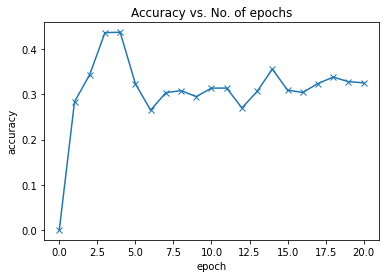

In [ ]:
plot_accuracies(history)

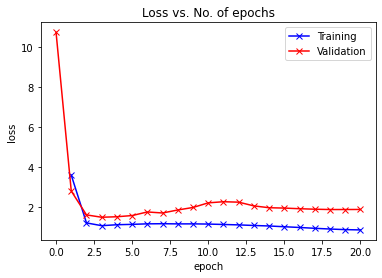

In [ ]:
plot_losses(history)

From the epoch vs loss graph we can see that firstly both the training data and testing data are decreasing simultaniously upto epoch 5.After that the training plotline started increasing for some time while the validation plotline is going parallely.

Initialy, both the training and validation losses seem to decrease over time. However, if you train the model for long enough, you will notice that the training loss continues to decrease, while the validation loss stops decreasing, and even starts to increase after a certain point!

<img src="https://vitalflux.com/wp-content/uploads/2020/12/overfitting-and-underfitting-wrt-model-error-vs-complexity.png"/>

This phenomenon is called overfitting, and it is the no. 1 why many machine learning models give rather terrible results on real-world data. It happens because the model, in an attempt to minimize the loss, starts to learn patters are are unique to the training data, sometimes even memorizing specific training examples. Because of this, the model does not generalize well to previously unseen data.

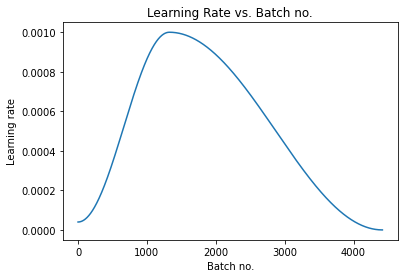

In [ ]:
plot_lrs(history)

#Testing the model against the test dataset to check the accuracy

In [ ]:
import random

In [ ]:
def denormalize(images, mean, std):
    invTrans = tt.Compose([ tt.Normalize(mean=[ 0., 0., 0. ],
                                                     std = [ 1/std[0], 1/std[1], 1/std[2] ]),
                                tt.Normalize(mean = [-1*mean[0], -1*mean[2], -1*mean[2] ],
                                                     std = [ 1., 1., 1. ]),
                               ])
    return invTrans(images)

In [ ]:
def predict_img(img, label):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, pred = torch.max(yb, dim=1)
    print(f'Label: {train_ds.classes[label]}, Predicted: {train_ds.classes[pred]}')
    img = denormalize(img, *stats)
    plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Angry, Predicted: Angry


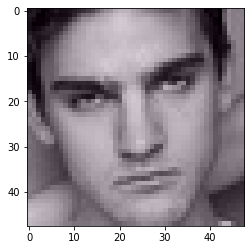

In [ ]:
predict_img(*test_ds[1])

Label: Sad, Predicted: Angry


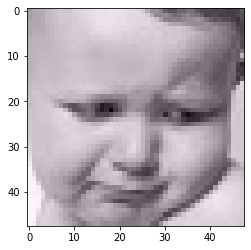

In [ ]:
predict_img(*test_ds[5000])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Angry, Predicted: Angry


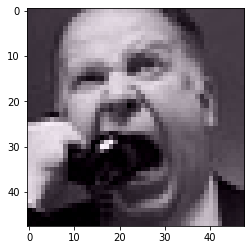

In [ ]:
predict_img(*test_ds[21])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Angry, Predicted: Angry


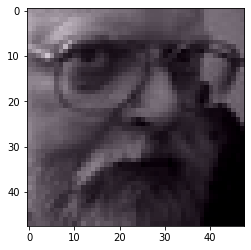

In [ ]:
predict_img(*test_ds[102])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Angry, Predicted: Fear


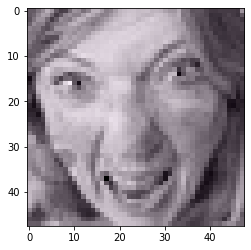

In [ ]:
predict_img(*test_ds[45])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Neutral, Predicted: Angry


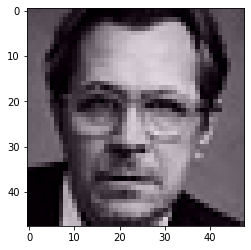

In [ ]:
predict_img(*test_ds[4000])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Sad, Predicted: Sad


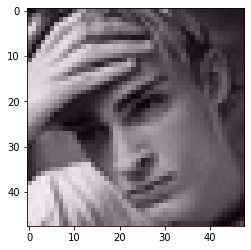

In [ ]:
predict_img(*test_ds[6000])

#Save the trained model

In [ ]:
torch.save(model.state_dict(), 'faces_desnet.pth')

#Conclusion:
Training for Facial expression recognition was much more difficult than I thought it would be, some expressions are fairly similar and it seems to create more error when trying to recognize certain expressions.

Maybe a bigger size picture Resize and Randomcrop can give a better result, but for that top quality, GPU is highly required otherwise it will give an "out of memory" error.

I also tried different learning rates and other approaches. Also tried DenseNet, but ResNet was better.